In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
random.seed(666)
torch.manual_seed(666)

# Load Data

In [3]:
from pathlib import Path
from npz_loader import build_episodes_from_sequences
from npz_loader import discover_game_npz_paths, get_sequences_by_game, fix_obs_paths, build_episodes_from_sequences

train_game_dirs = [
    Path(r"dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4"),

    Path(r"dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4"),
    Path(r"dataset\EnduroNoFrameskip-v4\EnduroNoFrameskip-v4"),
    Path(r"dataset\MsPacmanNoFrameskip-v4\MsPacmanNoFrameskip-v4"),
    # Path(r"dataset\PongNoFrameskip-v4\PongNoFrameskip-v4"),
    # Path(r"dataset\QbertNoFrameskip-v4\QbertNoFrameskip-v4"),
    # Path(r"dataset\SeaquestNoFrameskip-v4\SeaquestNoFrameskip-v4"),
    # Path(r"dataset\SpaceInvadersNoFrameskip-v4\SpaceInvadersNoFrameskip-v4"),
]

npz_paths_by_game = discover_game_npz_paths(train_game_dirs)
game_to_sequences = get_sequences_by_game(npz_paths_by_game)
sequences_by_game = fix_obs_paths(game_to_sequences, dataset_root="dataset")
episodes = build_episodes_from_sequences(sequences_by_game)

In [4]:
# Our data is big so cutting it down is good for testing (set between 0 and 1)
dataset_fraction = .1 

sample_size = max(1, int(len(episodes) * dataset_fraction))
sampled_episodes = random.sample(episodes, sample_size)
print(f"Sampled {len(sampled_episodes)} episodes ({len(sampled_episodes)/len(episodes)*100:.1f}% of {len(episodes)} total)")

Sampled 108 episodes (10.0% of 1080 total)


In [5]:
from episode_dataset import make_train_val_dataloaders

holdout_games = [
    Path(r"dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4").name
]

# Note that this function must be called for all data the model will see
# Otherwise the binning may not be correct for new data
main_bundle, holdout_bundle, bins = make_train_val_dataloaders(
    sampled_episodes,
    train_frac=0.9,
    timestep_window_size=4,
    image_size=(84, 84),
    batch_size=32,

    holdout_games=holdout_games
)

# Dataloader - Main Games

=== Dataloader Sanity Check: Main Train ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 3 -> {'EnduroNoFrameskip-v4': 1234, 'MsPacmanNoFrameskip-v4': 328, 'BreakoutNoFrameskip-v4': 38}
Actions: min=0, max=8, unique=9
Rewards: min=-1.000, max=1.000
RTG: min=-13.000, max=185.000
Reward bins: unique=[0 1 2]
RTG bins: min=1, max=199
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'EnduroNoFrameskip-v4': 1234, 'MsPacmanNoFrameskip-v4': 328, 'BreakoutNoFrameskip-v4': 38}, 'actions_min': 0.0, 'actions_max': 8.0, 'n_unique_actions': 9, 'rewards_min': -1.0, 'rewards_max': 1.0, 'rtg_min': -13.0, 'rtg_max': 185.0, 'reward_bins_unique': array([0, 1, 2]), 'rtg_bins_min': 1, 'rtg_bins_max': 199}


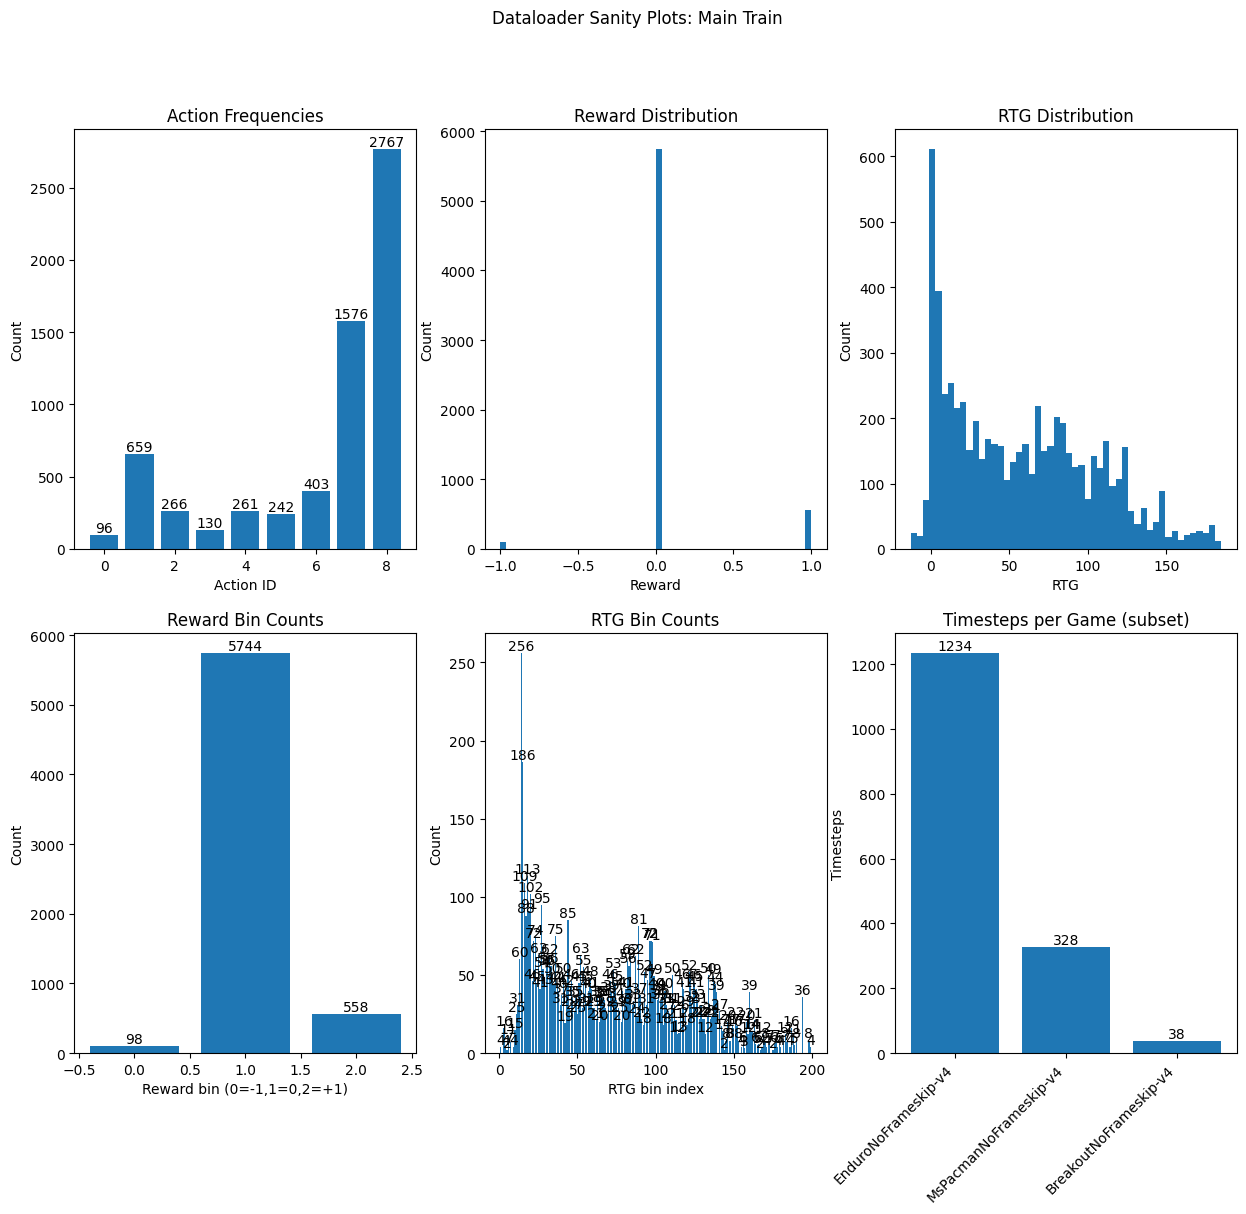

=== Dataloader Sanity Check: Main Validate ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 2 -> {'MsPacmanNoFrameskip-v4': 806, 'EnduroNoFrameskip-v4': 794}
Actions: min=0, max=8, unique=9
Rewards: min=-1.000, max=1.000
RTG: min=0.000, max=184.000
Reward bins: unique=[0 1 2]
RTG bins: min=14, max=198
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'MsPacmanNoFrameskip-v4': 806, 'EnduroNoFrameskip-v4': 794}, 'actions_min': 0.0, 'actions_max': 8.0, 'n_unique_actions': 9, 'rewards_min': -1.0, 'rewards_max': 1.0, 'rtg_min': 0.0, 'rtg_max': 184.0, 'reward_bins_unique': array([0, 1, 2]), 'rtg_bins_min': 14, 'rtg_bins_max': 198}


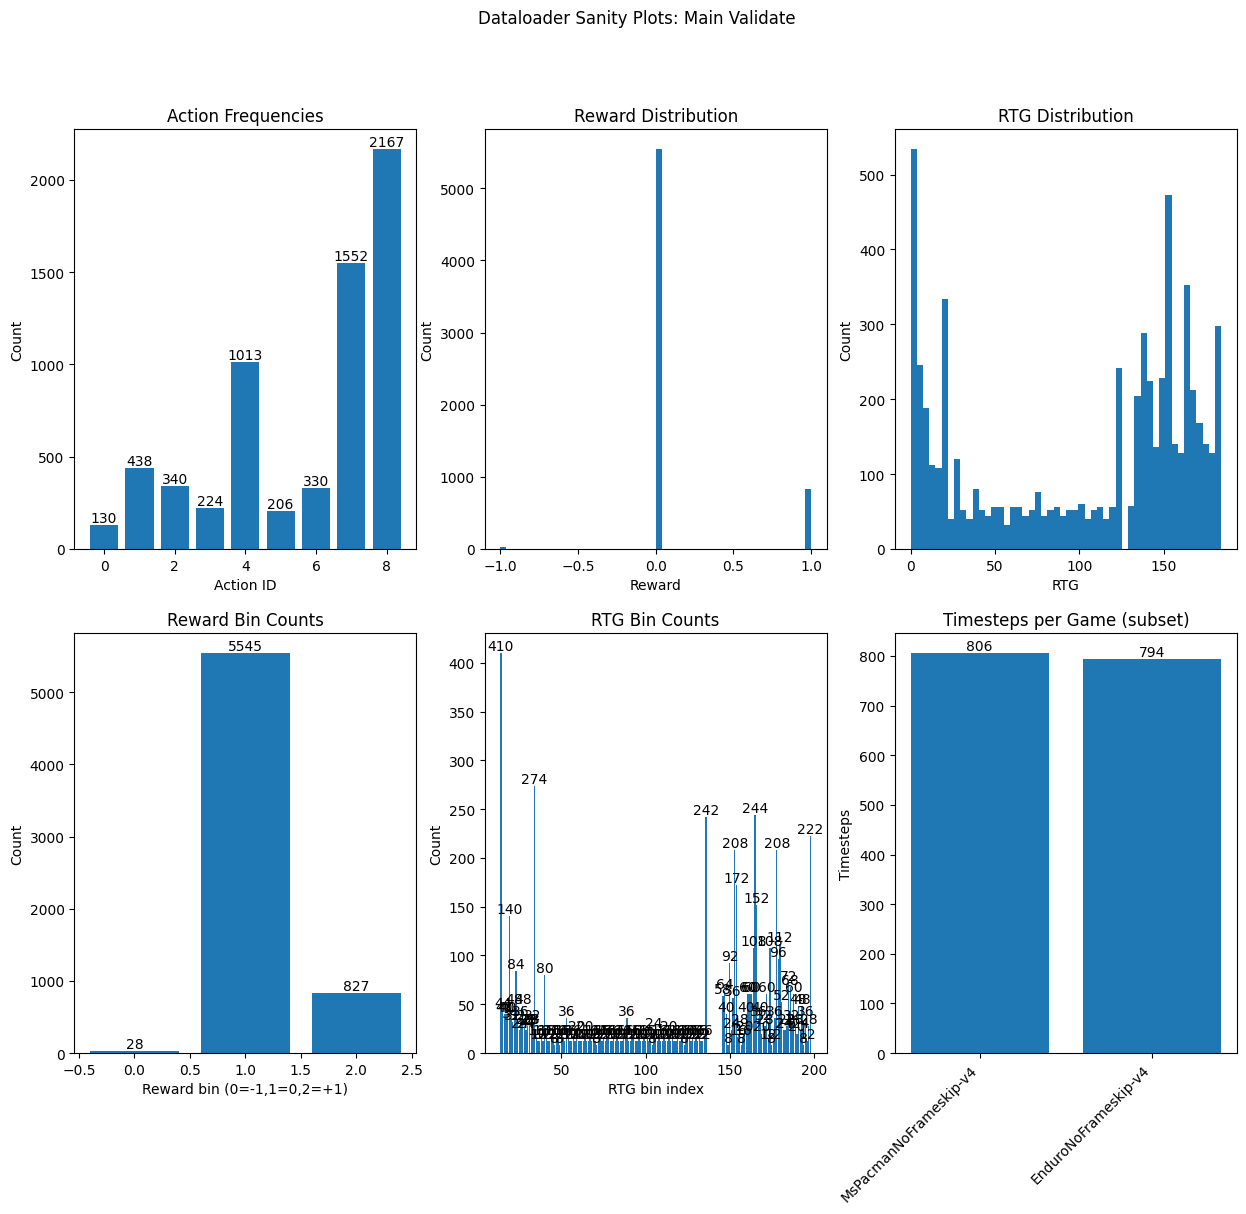

In [6]:
from dataloader_stats import inspect_dataloader

inspect_dataloader(main_bundle.train_loader, "Main Train")
inspect_dataloader(main_bundle.val_loader, "Main Validate")

# Dataloader - Holdout Games

=== Dataloader Sanity Check: Holdout Train ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 1 -> {'BeamRiderNoFrameskip-v4': 1600}
Actions: min=0, max=8, unique=9
Rewards: min=0.000, max=1.000
RTG: min=0.000, max=15.000
Reward bins: unique=[1 2]
RTG bins: min=14, max=29
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'BeamRiderNoFrameskip-v4': 1600}, 'actions_min': 0.0, 'actions_max': 8.0, 'n_unique_actions': 9, 'rewards_min': 0.0, 'rewards_max': 1.0, 'rtg_min': 0.0, 'rtg_max': 15.0, 'reward_bins_unique': array([1, 2]), 'rtg_bins_min': 14, 'rtg_bins_max': 29}


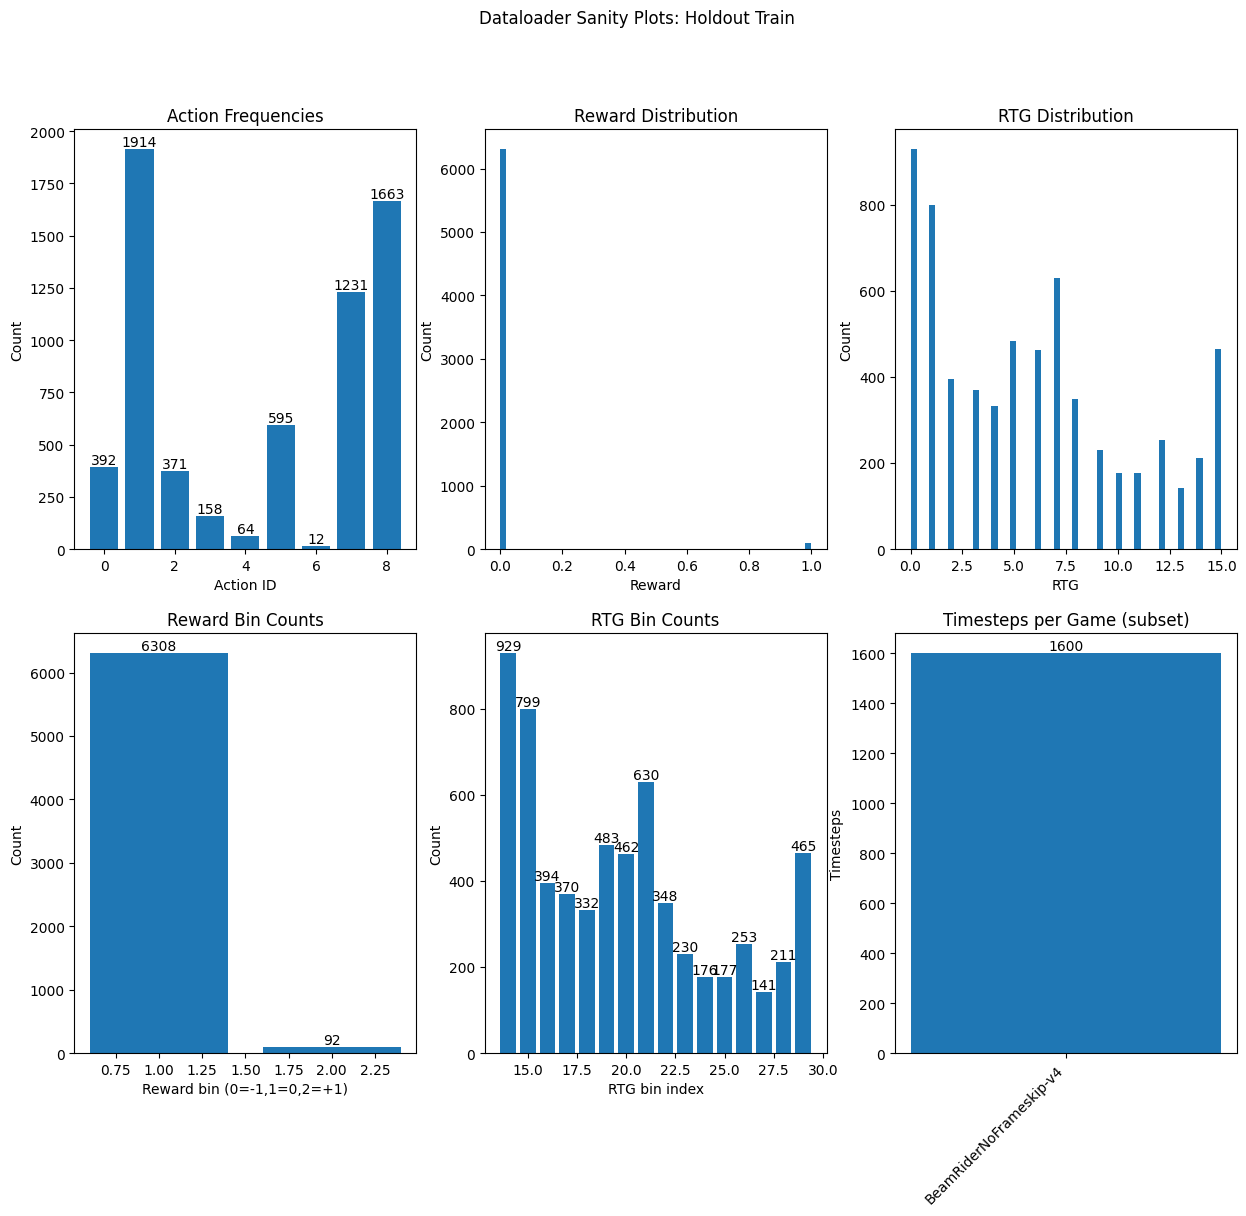

=== Dataloader Sanity Check: Holdout Validate ===
Used batches: 45
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 5720
Games in subset: 1 -> {'BeamRiderNoFrameskip-v4': 1430}
Actions: min=0, max=8, unique=9
Rewards: min=0.000, max=1.000
RTG: min=0.000, max=15.000
Reward bins: unique=[1 2]
RTG bins: min=14, max=29
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 45, 'n_timesteps': 5720, 'game_counts': {'BeamRiderNoFrameskip-v4': 1430}, 'actions_min': 0.0, 'actions_max': 8.0, 'n_unique_actions': 9, 'rewards_min': 0.0, 'rewards_max': 1.0, 'rtg_min': 0.0, 'rtg_max': 15.0, 'reward_bins_unique': array([1, 2]), 'rtg_bins_min': 14, 'rtg_bins_max': 29}


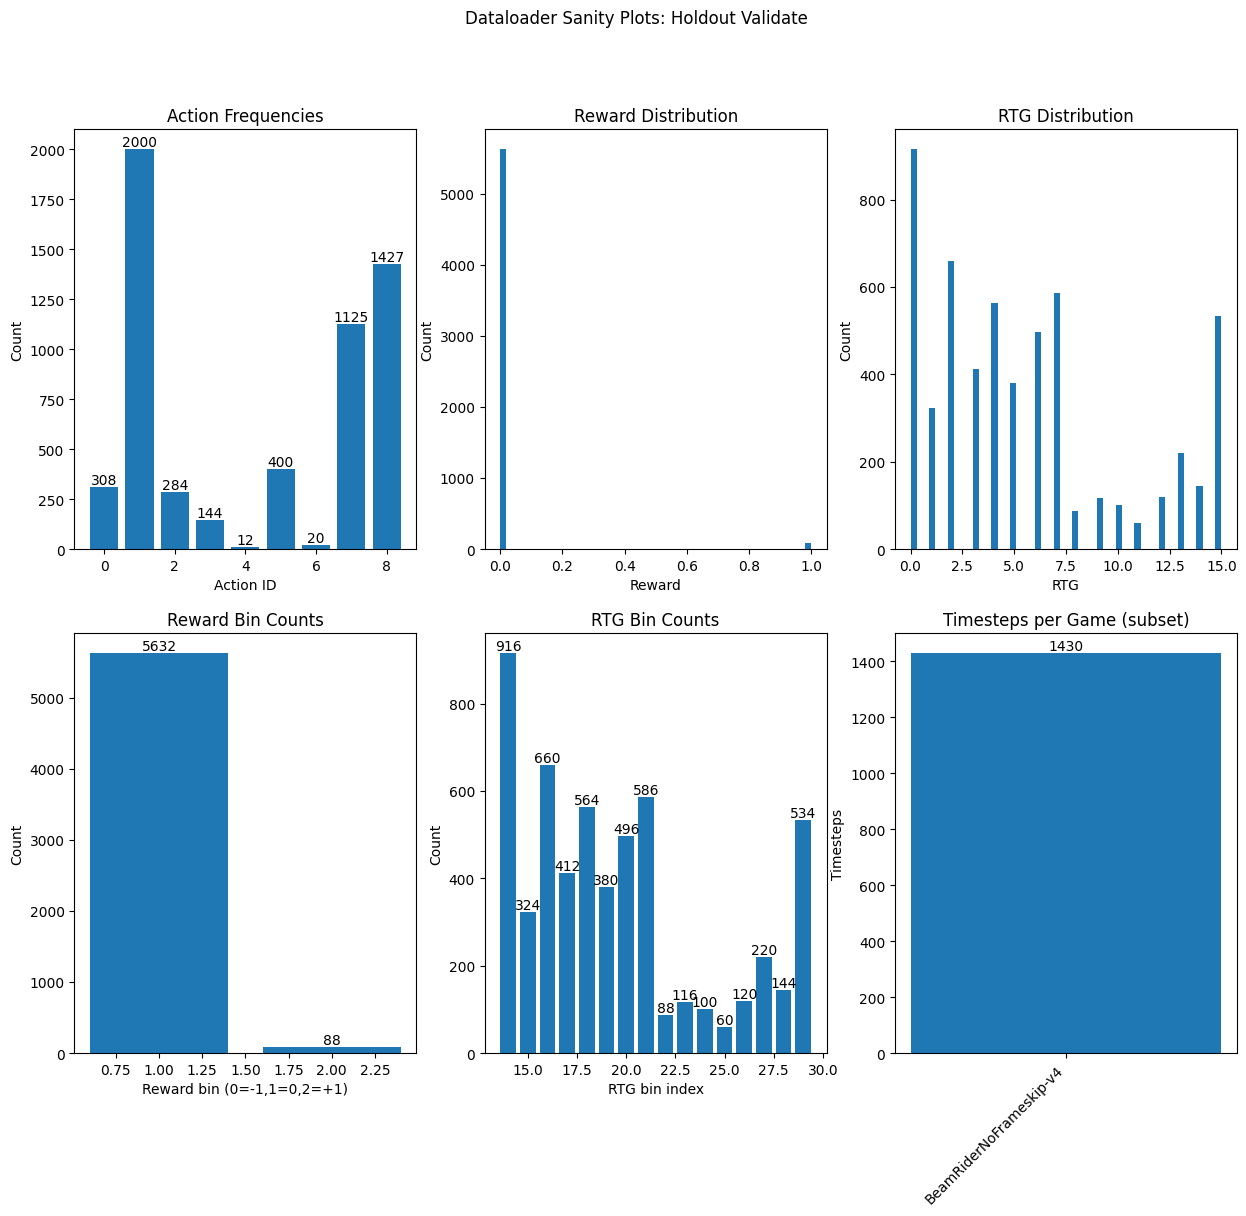

In [7]:
inspect_dataloader(holdout_bundle.train_loader, "Holdout Train")
inspect_dataloader(holdout_bundle.val_loader, "Holdout Validate")

# Train - Main Games

In [ ]:
from mgdt_model_trainer import Encoder, train_mgdt

model, main_train_stats, main_val_stats = train_mgdt(
    bins=bins,
    dataloader_train=main_bundle.train_loader,
    dataloader_val=main_bundle.val_loader,
    encoder_type=Encoder.Patch,
    num_epochs=2,
)

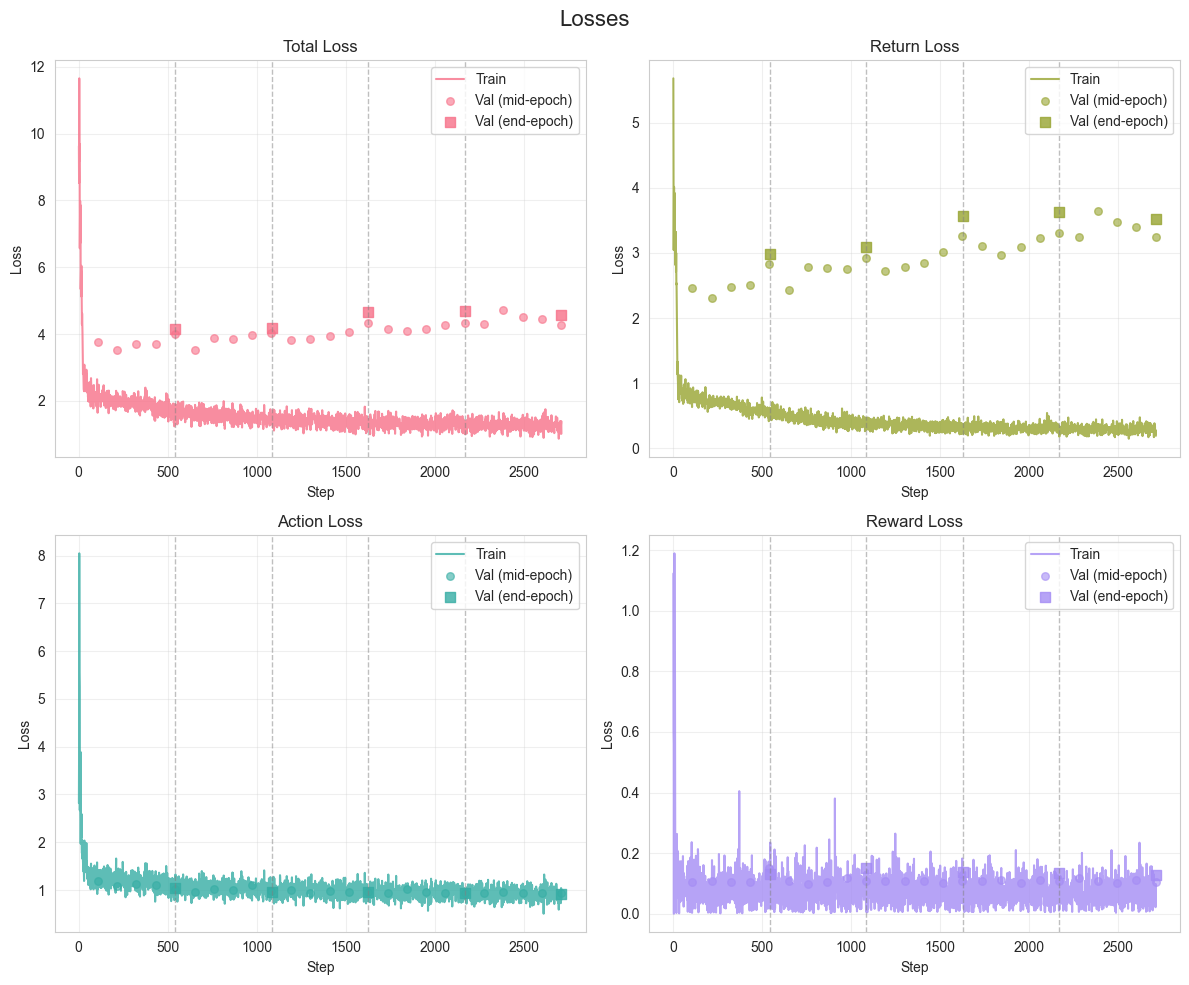

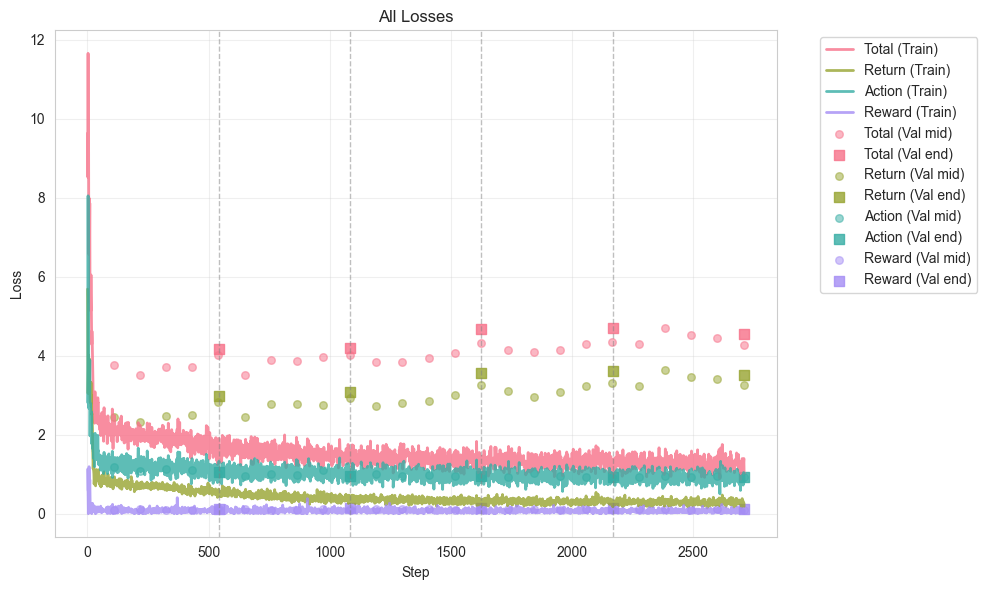

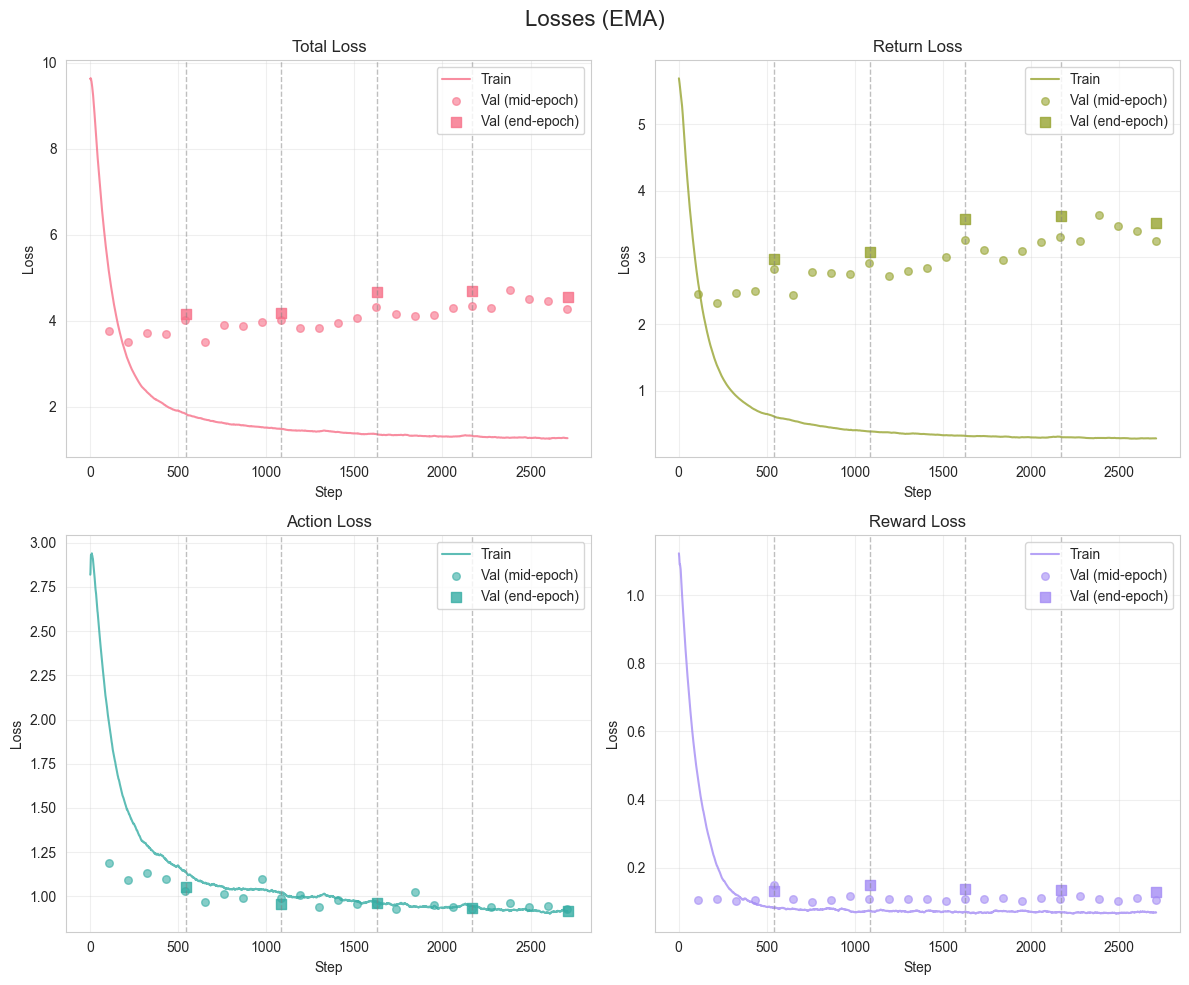

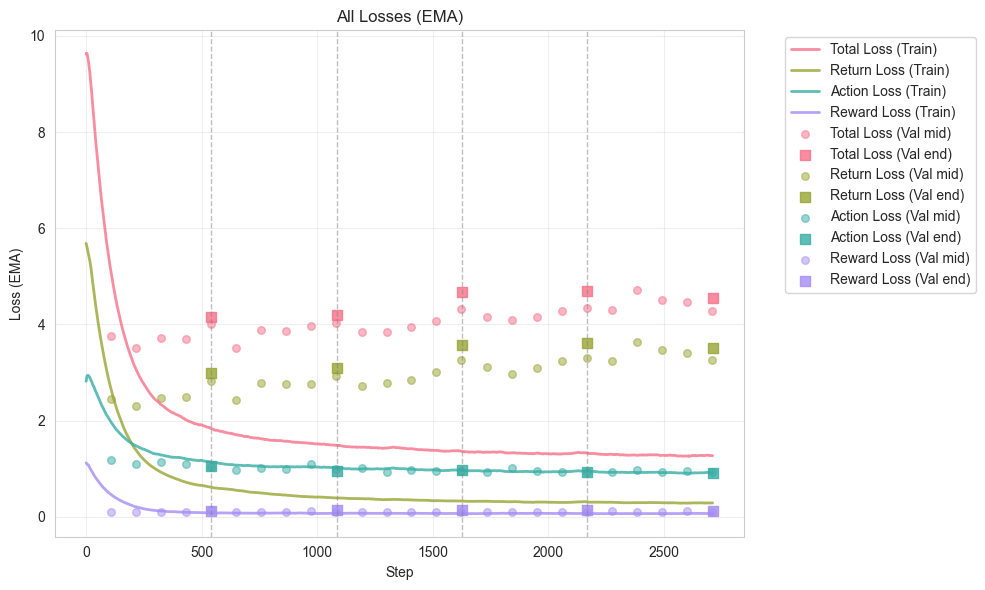

In [ ]:
from mgdt_model_stats import plot_losses
plot_losses(main_train_stats, main_val_stats)

# Train - Holdout Games

In [ ]:
from mgdt_model_trainer import Encoder, train_mgdt

model, holdout_train_stats, holdout_val_stats = train_mgdt(
    model=model,
    bins=bins,
    dataloader_train=holdout_bundle.train_loader,
    dataloader_val=holdout_bundle.val_loader,
    encoder_type=Encoder.Patch,
    num_epochs=1,
)

In [ ]:
from mgdt_model_stats import plot_losses
plot_losses(holdout_train_stats, holdout_val_stats)

# Model Info and Save

In [ ]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total parameters: {total_params/1e6:.0f}M")

Total parameters: 20M


In [ ]:
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass
from typing import List, Dict, Any

@dataclass
class ModelCheckpoint:
    model: torch.nn.Module
    train_stats: List[Dict[str, Any]]
    val_stats: List[Dict[str, Any]]

timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M")
checkpoint = ModelCheckpoint(
    model=model,
    train_stats=main_train_stats,
    val_stats=main_val_stats
)
model_path = Path(f"output/model_{timestamp}.pt")
torch.save(checkpoint, model_path)
print(f"Model and stats saved to {model_path}")

Model saved to output\model.pkl
